### Importamos librerías

In [22]:
import os
import tweepy as tw
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
import seaborn as sns

### Credenciales para el uso de la API


In [70]:
consumer_key= 'mEfV8N05qpt3kVQFP2wD5swU5'
consumer_secret= 'vs7zg1AvjK9GUCcYwbQxjypT0h65XdDHurMoopQXzuqnwoRTNY'
access_token= '1267192889416847362-3bkTrmyabVIbjlkpfZRIfsGD0LqwRv'
access_token_secret= 'Sl7gnnajauTISKig3FWiluwWibJXsgYTstuF0JUJta7Qu'

In [71]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [72]:
# Creamos una función que nos devuelve la información de los tweets que deseamos

def api_tweets(key_words, language, date_start, n_tweets):

  result = tw.Cursor(api.search,
                    q=key_words,
                    lang=language,
                    since=date_start,
                    tweet_mode='extended').items(n_tweets)

  return result

In [73]:
search_words = ("#telefonica")
lang = "es"
date_since = "2020-06-01"
n_tweets = 500

tweets = api_tweets(search_words, lang, date_since, n_tweets)

In [74]:
'''
for tweet in tweets:
  tweet_d = dict(tweet._json)
  print(tweet_d['coordinates'])
'''

"\nfor tweet in tweets:\n  tweet_d = dict(tweet._json)\n  print(tweet_d['coordinates'])\n"

### Creamos el dataframe

In [75]:
# Creamos un df vacío con las columnas que vamos a completar

df = pd.DataFrame(columns=['text', 'created_at', 'created_at_time', 'created_at_hour', 'retweeted', 'retweet_count', 'favorite_count', 
                           'user_ verified', 'user_id', 'user_name', 'user_location', 'user_notificacion', 'user_followers', 'user_friends', 
                           'user_withheld_in_countries', 'mentions_in_tweet', 'is_reply', 'source_device', 'finished_tweet', 
                           'status_count', 'hashtags_text','hastags_indices', 'hastags_in_tweet'])

i = 0

for tweet in tweets:

    # Convertimos el json de cada uno de los tweets en un diccionario
    tweet_d = dict(tweet._json)

    # Creo un estado para coger el texto completo
    status = api.get_status(tweet_d['id'], tweet_mode="extended")
    try:
      text = status.retweeted_status.full_text
      rt = 'Si'
    except AttributeError:  # Not a Retweet
      text = status.full_text
      rt = 'No'
    
    # Creamos una variable que nos dice el número de menciones en el tweet
    try:
        mentions_in_tweet = len(tweet_d['entities']['user_mentions'])
    except:
        mentions_in_tweet = 0

    # Creamos una variable que nos dice si el tweet es una respuesta
    if tweet_d['in_reply_to_screen_name'] == None:
      reply = 'No'
    else:
      reply = tweet_d['in_reply_to_screen_name']

    # Cogemos la fecha del tweet y dividimos en día y hora
    fecha_completa = str(tweet_d['created_at'])
    fecha = fecha_completa.split(sep = ' ')
    texts_date = ' '.join(elemento for elemento in fecha[0:3])
    texts_time = fecha[3] 

    # Creamos una columna que corresponde con las horas, para representarla
    hora = fecha[3].split(sep = ':')
    texts_hour = int(hora[0])

    # Exportamos los hastag del tweet y las posiciones
    aux = list([i["text"] for i in tweet.entities['hashtags']]) 
    aux_pos = [i["indices"] for i in tweet.entities['hashtags']]
    
    # Creamos una fila con la información que queremos almacenar de cara al análisis
    new_row = {
        
    'text': text,

    'created_at': texts_date,
    'created_at_time': texts_time,
    'created_at_hour': texts_hour,

    'retweeted': rt,

    'retweet_count': tweet_d['retweet_count'],
    'favorite_count': tweet_d['favorite_count'],

    'user_verified': tweet_d['user']['verified'], # ---------------------- ALGO PASA CON ESTO, DEVUELVE TODO NaN
    'user_id': tweet_d['user']['id'],
    'user_name': tweet_d['user']['screen_name'],
    'user_location': tweet_d['user']['location'],
    'user_notificacion': tweet.user.notifications,
    'user_followers': tweet_d['user']['followers_count'],
    'user_friends': tweet_d['user']['friends_count'],
    'user_withheld_in_countries':  tweet.user.withheld_in_countries,

    'mentions_in_tweet': mentions_in_tweet,   
    'is_reply': reply,

    'source_device':tweet.source,
    'finished_tweet': tweet.truncated, # Si está incompleto el tweet (hilo)

    'status_count':tweet.user.statuses_count, # ¿QUÉ ES ESTO? interacciones del usuario tanto tweets como retweets 

    'hashtags_text': aux,
    'hastags_indices': aux_pos,
    'hastags_in_tweet': len(aux)

    }
    
    # Añadimos la info al dataframe en una nueva fila
    df.loc[i] = new_row

    i = i + 1


Función para ver si es hay una URL en el tweet


In [76]:
#Regular expresion para capturar urls
url_re = "https://[^\s]+"

In [77]:
df['URLs'] = df['text'].apply(lambda x: re.findall(url_re, x))
df['text'] = df['text'].apply(lambda x: re.sub(url_re, 'url', x))

In [78]:
df

,text,created_at,created_at_time,created_at_hour,retweeted,retweet_count,favorite_count,user_ verified,user_id,user_name,user_location,user_notificacion,user_followers,user_friends,user_withheld_in_countries,mentions_in_tweet,is_reply,source_device,finished_tweet,status_count,hashtags_text,hastags_indices,hastags_in_tweet,URLs
0,@esotobordoy @AcLabEsp @teleAfonica @ESKsindik...,Thu Jul 22,06:31:32,6,Si,2,0,NaN,3293713167,librevioleta,,False,673,416,[],5,No,Twitter for Android,False,73255,"[Comfica, Bizkaia]","[[75, 83], [84, 92]]",2,[https://t.co/YzpzhdXZ3q]
1,@esotobordoy @AcLabEsp @teleAfonica @ESKsindik...,Thu Jul 22,06:30:40,6,Si,2,0,NaN,813539044835651584,AcLabEsp,España,False,17965,176,[],5,No,Twitter Web App,False,8000,"[Comfica, Bizkaia]","[[75, 83], [84, 92]]",2,[https://t.co/YzpzhdXZ3q]
2,👁‍🗨Prórroga II #ConvenioEmpresasVinculadas: Qu...,Thu Jul 22,05:45:25,5,Si,5,0,NaN,1941702800,carmenrai67,,False,112,323,[],1,No,Twitter for Android,False,1166,[ConvenioEmpresasVinculadas],"[[29, 56]]",1,"[https://t.co/ywGyqsnlZm, https://t.co/6oe5shO..."
3,Según los resultados del primer Ranking de la ...,Thu Jul 22,03:53:49,3,Si,79,0,NaN,43921646,fondecard,PERU,False,60,170,[],2,No,Twitter for Android,False,412,[Telefónica],"[[105, 116]]",1,[https://t.co/T01BFINwCV]
4,#Nacionales #empresa #telefónica Movistar Vene...,Thu Jul 22,01:25:25,1,No,0,0,NaN,816285077432844289,QPEV_,"Caracas, Venezuela",False,8490,3032,[],0,No,qpev20212,False,683872,"[Nacionales, empresa, telefónica]","[[0, 11], [12, 20], [21, 32]]",3,"[https://t.co/vVst3K7ZWk., https://t.co/lIDyF4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,#Telefónica acudirá a la subasta #5G de la ban...,Wed Jul 14,08:58:14,8,No,0,0,NaN,4118574268,economiadehoyes,"Madrid, Comunidad de Madrid",False,1200,550,[],0,No,Twitter Web App,False,66980,"[Telefónica, 5G, liderazgo, conectividad]","[[0, 11], [33, 36], [76, 86], [90, 103]]",4,"[https://t.co/ykPIAw64cx, https://t.co/buHLmbS..."
348,Por qué no debes contratar los 600 Mb de O2 ur...,Wed Jul 14,08:14:51,8,Si,3,0,NaN,2667397983,lezmanu,,False,1208,1807,[],1,No,Twitter for Android,False,67349,"[o2, movistar, telefonica]","[[86, 89], [90, 99], [100, 111]]",3,"[https://t.co/E0QONISUcz, https://t.co/UhSRBzL..."
349,Ya esta en las líneas Xar y parece que ha sido...,Wed Jul 14,08:05:02,8,No,0,0,NaN,218592490,MaxgloOpinion,"Las Palmas, Islas Canarias",False,1915,0,[],0,No,Twitter Web App,False,15923,[telefónica],"[[81, 92]]",1,"[https://t.co/BTIKpEJ4Vy, https://t.co/z9IlhrR..."
350,Por qué no debes contratar los 600 Mb de O2 ur...,Wed Jul 14,08:01:32,8,No,3,5,NaN,47988646,bandaanchaeu,España,False,4472,486,[],0,No,TweetDeck,False,7114,"[o2, movistar, telefonica]","[[68, 71], [72, 81], [82, 93]]",3,"[https://t.co/E0QONISUcz, https://t.co/UhSRBzL..."


Creamos una variable 'texto_limpio', en la que copiamos el texto del tweet sin URL, de cara a que la limpieza sea más efectiva. Además creamos la variable URL en la que se especifican las url en caso de que existan.

 He leído tweets con 'llamada telefonica' o 'linea telefónica' en tweets relacionados con la situación en Cuba. ¿cómo veis que los quitemos? o al menos que quede notificado...

 No se si se podrían eliminar aquellos tweets que "telefónica" sea un **adjetivo**.... sería mejor porque sino habra que  apuntar miles de regex


In [79]:
# Expresiones regulares
re_0 = "llamada\stelefónica" 
re_1 = "linea\stelefónica"
re_2 = "compañía\stelefónica" 
re_3 = "atención\stelefónica"
re_4 = "factura\stelefónica"

In [80]:
'''
def not_enterprise(tweet, *args):
    """
    Funcion que dada un tweet busca si contiene alguna de las varias expresiones regualares dadas
    
    params: 
        tweet (string): texto que contiene el tweet
        args* (string): Expresiones regulares a considerar
        
    return: Boolean
        True si el tweet contiene al menos una de las expresiones regulares, False en caso contrario
    """
    return any(re.search(regex, tweet) for regex in args)
  '''

'\ndef not_enterprise(tweet, *args):\n    """\n    Funcion que dada un tweet busca si contiene alguna de las varias expresiones regualares dadas\n    \n    params: \n        tweet (string): texto que contiene el tweet\n        args* (string): Expresiones regulares a considerar\n        \n    return: Boolean\n        True si el tweet contiene al menos una de las expresiones regulares, False en caso contrario\n    """\n    return any(re.search(regex, tweet) for regex in args)\n  '

In [81]:
'''
df['not_enterprise'] = df['text_limpio'].apply(lambda x: not_enterprise(x, re_0, re_1, re_2, re_3))
'''

"\ndf['not_enterprise'] = df['text_limpio'].apply(lambda x: not_enterprise(x, re_0, re_1, re_2, re_3))\n"

In [82]:
df

,text,created_at,created_at_time,created_at_hour,retweeted,retweet_count,favorite_count,user_ verified,user_id,user_name,user_location,user_notificacion,user_followers,user_friends,user_withheld_in_countries,mentions_in_tweet,is_reply,source_device,finished_tweet,status_count,hashtags_text,hastags_indices,hastags_in_tweet,URLs
0,@esotobordoy @AcLabEsp @teleAfonica @ESKsindik...,Thu Jul 22,06:31:32,6,Si,2,0,NaN,3293713167,librevioleta,,False,673,416,[],5,No,Twitter for Android,False,73255,"[Comfica, Bizkaia]","[[75, 83], [84, 92]]",2,[https://t.co/YzpzhdXZ3q]
1,@esotobordoy @AcLabEsp @teleAfonica @ESKsindik...,Thu Jul 22,06:30:40,6,Si,2,0,NaN,813539044835651584,AcLabEsp,España,False,17965,176,[],5,No,Twitter Web App,False,8000,"[Comfica, Bizkaia]","[[75, 83], [84, 92]]",2,[https://t.co/YzpzhdXZ3q]
2,👁‍🗨Prórroga II #ConvenioEmpresasVinculadas: Qu...,Thu Jul 22,05:45:25,5,Si,5,0,NaN,1941702800,carmenrai67,,False,112,323,[],1,No,Twitter for Android,False,1166,[ConvenioEmpresasVinculadas],"[[29, 56]]",1,"[https://t.co/ywGyqsnlZm, https://t.co/6oe5shO..."
3,Según los resultados del primer Ranking de la ...,Thu Jul 22,03:53:49,3,Si,79,0,NaN,43921646,fondecard,PERU,False,60,170,[],2,No,Twitter for Android,False,412,[Telefónica],"[[105, 116]]",1,[https://t.co/T01BFINwCV]
4,#Nacionales #empresa #telefónica Movistar Vene...,Thu Jul 22,01:25:25,1,No,0,0,NaN,816285077432844289,QPEV_,"Caracas, Venezuela",False,8490,3032,[],0,No,qpev20212,False,683872,"[Nacionales, empresa, telefónica]","[[0, 11], [12, 20], [21, 32]]",3,"[https://t.co/vVst3K7ZWk., https://t.co/lIDyF4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,#Telefónica acudirá a la subasta #5G de la ban...,Wed Jul 14,08:58:14,8,No,0,0,NaN,4118574268,economiadehoyes,"Madrid, Comunidad de Madrid",False,1200,550,[],0,No,Twitter Web App,False,66980,"[Telefónica, 5G, liderazgo, conectividad]","[[0, 11], [33, 36], [76, 86], [90, 103]]",4,"[https://t.co/ykPIAw64cx, https://t.co/buHLmbS..."
348,Por qué no debes contratar los 600 Mb de O2 ur...,Wed Jul 14,08:14:51,8,Si,3,0,NaN,2667397983,lezmanu,,False,1208,1807,[],1,No,Twitter for Android,False,67349,"[o2, movistar, telefonica]","[[86, 89], [90, 99], [100, 111]]",3,"[https://t.co/E0QONISUcz, https://t.co/UhSRBzL..."
349,Ya esta en las líneas Xar y parece que ha sido...,Wed Jul 14,08:05:02,8,No,0,0,NaN,218592490,MaxgloOpinion,"Las Palmas, Islas Canarias",False,1915,0,[],0,No,Twitter Web App,False,15923,[telefónica],"[[81, 92]]",1,"[https://t.co/BTIKpEJ4Vy, https://t.co/z9IlhrR..."
350,Por qué no debes contratar los 600 Mb de O2 ur...,Wed Jul 14,08:01:32,8,No,3,5,NaN,47988646,bandaanchaeu,España,False,4472,486,[],0,No,TweetDeck,False,7114,"[o2, movistar, telefonica]","[[68, 71], [72, 81], [82, 93]]",3,"[https://t.co/E0QONISUcz, https://t.co/UhSRBzL..."


## Feature engineering

- VARIABLE URL !!  ✔
- Limpiar user location 
- Buscar outliers con los seguidores y los seguidos (spam) ✔
- Estudiar si la hora de tweet tiene que ver (buscar outliers) 
- Buscar atípicos en n_menciones y n_hastag (spam) ✔
- User verified ¿afecta? (verificados = publi) --- **¿que pasa con esta variable??**???? Sale NaN
- Bucar patrones publicitarios (#Publi, #Descuento, etc.)

## Imputar variables numéricas

Ya está el criterio, decidir las imputaciones.

## Estudio variables categóricas 

**En proceso**

### Pasar a formato correcto


*   0   text                        100 non-null    object    -->str
*   1   created_at                  100 non-null    object    -->date
*   2   created_at_time             100 non-null    object    -->hora
*   3   created_at_hour             100 non-null    object    -->int
*   4   retweeted                   100 non-null    object    -->str
*   5   retweet_count               100 non-null    object    -->int
*   6   favorite_count              100 non-null    object    -->int
*   7   user_ verified              0 non-null      object    -->str
*   8   user_id                     100 non-null    object    -->int
*   9   user_name                   100 non-null    object    -->str
*   10  user_location               100 non-null    object    -->str
*   11  user_notificacion           100 non-null    object    -->str
*   12  user_followers              100 non-null    object    -->int
*   13  user_friends                100 non-null    object    -->int
*   14  user_withheld_in_countries  100 non-null    object    -->str
*   15  mentions_in_tweet           100 non-null    object    -->int
*   16  is_reply                    100 non-null    object    -->str
*   17  source_device               100 non-null    object    -->str
*   18  finished_tweet              100 non-null    object    -->str
*   19  status_count                100 non-null    object    -->int
*   20  hashtags_text               100 non-null    object    -->str
*   21  hastags_indices             100 non-null    object    -->int
*   22  hastags_in_tweet            100 non-null    object    -->int
*   23  text_limpio                 100 non-null    object    -->str
*   24  url                         100 non-null    object    -->str
*   25  URLs                        100 non-null    object    -->str

In [83]:
df['created_at_hour']= df['created_at_hour'].astype(int)
df['retweet_count'] = df['retweet_count'].astype(int)
df['favorite_count'] = df['favorite_count'].astype(int)
df['user_id'] = df['user_id'].astype(int)
df['user_followers'] = df['user_followers'].astype(int)
df['user_friends'] = df['user_friends'].astype(int)
df['mentions_in_tweet'] = df['mentions_in_tweet'].astype(int)
df['status_count'] = df['status_count'].astype(int)
# df['hastags_indices'].astype(int)
df['hastags_in_tweet'] = df['hastags_in_tweet'].astype(int)

In [84]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,created_at_hour,retweet_count,favorite_count,user_id,user_followers,user_friends,mentions_in_tweet,status_count,hastags_in_tweet
0,6,2,0,3293713167,673,416,5,73255,2
1,6,2,0,813539044835651584,17965,176,5,8000,2
2,5,5,0,1941702800,112,323,1,1166,1
3,3,79,0,43921646,60,170,2,412,1
4,1,0,0,816285077432844289,8490,3032,0,683872,3


In [85]:
df['text'] = df['text'].astype(str)
df['retweeted'] = df['retweeted'].astype(str)
df['user_location'] = df['user_location'].astype(str)
df['user_name'] = df['user_name'].astype(str)
df['retweeted'] = df['retweeted'].astype(str)
df['user_notificacion'] = df['user_notificacion'].astype(str)
df['source_device'] = df['source_device'].astype(str)
df['is_reply'] = df['is_reply'].astype(str)
df['hashtags_text'] = df['hashtags_text'].astype(str) # ????? lo dejamos objeto
#df['URLs'] = df['URLs'].astype(str) # ??? lo dejamos en objeto
# df['text_limpio'] = df['text_limpio'].astype(str)
df['user_withheld_in_countries'] = df['user_withheld_in_countries'].astype(str)

In [86]:
df_num.describe()

,created_at_hour,retweet_count,favorite_count,user_id,user_followers,user_friends,mentions_in_tweet,status_count,hastags_in_tweet
count,352.000000,352.000000,352.000000,3.520000e+02,352.000000,352.000000,352.000000,3.520000e+02,352.000000
mean,13.877841,40.849432,2.375000,3.840098e+17,7418.988636,1173.153409,1.116477,8.783702e+04,2.502841
std,6.076846,48.756708,24.607836,5.173078e+17,33065.597031,3096.562739,0.955155,1.980530e+05,2.240521
min,0.000000,0.000000,0.000000,1.063779e+07,1.000000,0.000000,0.000000,1.000000e+00,0.000000
25%,9.000000,1.000000,0.000000,2.409857e+08,102.750000,153.000000,0.000000,4.633250e+03,1.000000
50%,15.000000,5.000000,0.000000,1.718532e+09,341.000000,486.000000,1.000000,1.956200e+04,2.000000
75%,19.000000,79.000000,0.000000,8.760447e+17,1349.500000,1157.000000,2.000000,6.798675e+04,3.000000
max,23.000000,118.000000,334.000000,1.412809e+18,486278.000000,42649.000000,6.000000,1.496435e+06,16.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


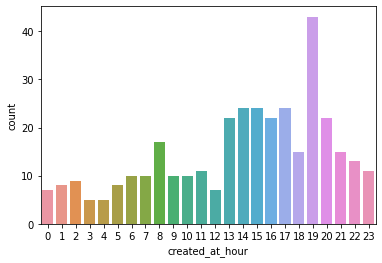

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


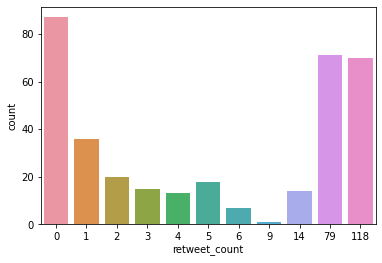

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


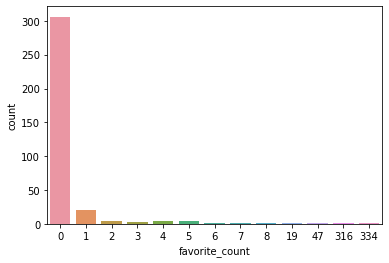

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


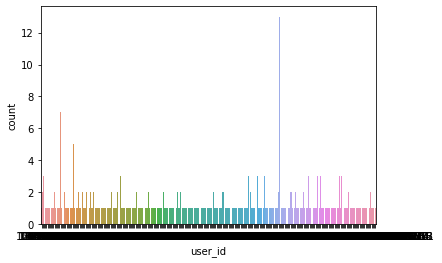

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


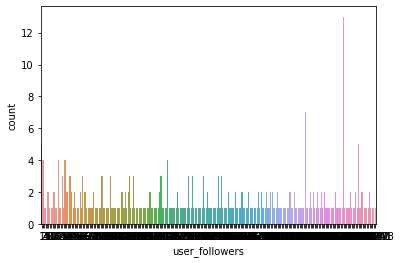

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


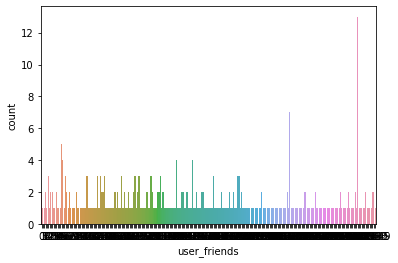

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


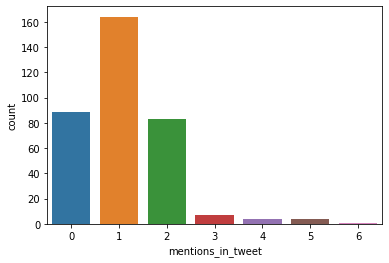

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


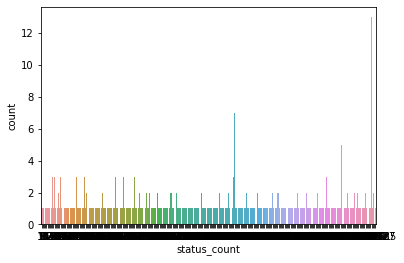

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


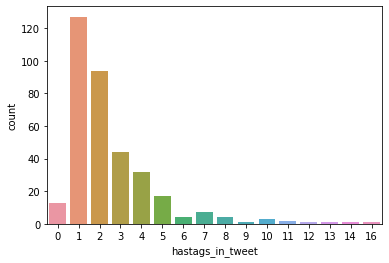

In [87]:
for col in df_num:
 sns.countplot(df_num[col])
 plt.show()

## Tratamiento 'user_friends'


*  Atipicos =   1157.56 + 1,5 * 2938.8 = 5565
*  Atipicos extremo =  la media + 3 * std = 9973


Proponemos que los usuarios con mas de 5,5k seguidos tomarlos como atipicos.

Pasamos a NaN e imputamos???

count      352.000000
mean      1173.153409
std       3096.562739
min          0.000000
25%        153.000000
50%        486.000000
75%       1157.000000
max      42649.000000
Name: user_friends, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


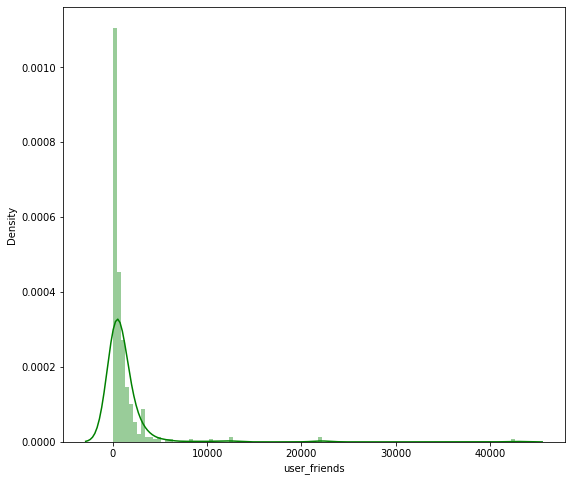

In [88]:
print(df['user_friends'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['user_friends'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Tratamiento 'user_followers'

*  Atipicos =   6891.64 + 1,5 * 19611,3 = 36308
*  Atipicos extremo =  6891.64 + 3 * 19611,3 = 65725


Pasamos a NaN e imputamos???


count       167.000000
mean       6891.646707
std       19611.297636
min           1.000000
25%         144.500000
50%         565.000000
75%        1766.500000
max      122378.000000
Name: user_followers, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


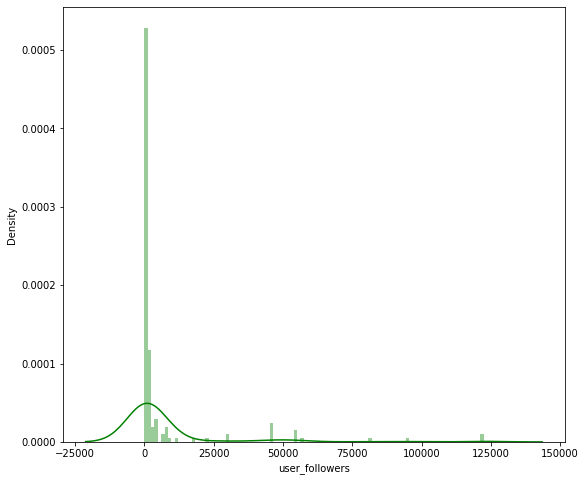

In [ ]:
print(df['user_followers'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['user_followers'], color='g', bins=100, hist_kws={'alpha': 0.4});

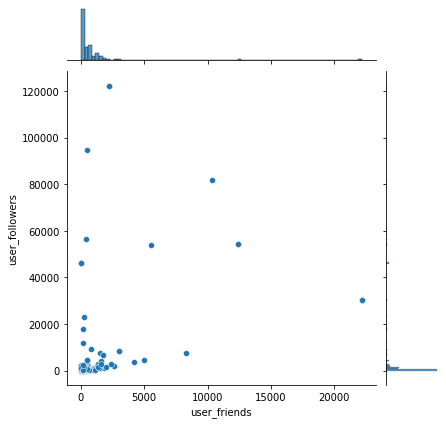

In [ ]:
sns.jointplot(x='user_friends', y='user_followers', data=df, kind='scatter') #  hue = 'user_verified'
plt.show()

## Tratamiento 'hastags_in_tweet'

*  Atipicos =   3,13 + 1,5 * 2,75 = 7.25
*  Atipicos extremo =  3,13 + 3 * 2,75 = 11.38

count    167.000000
mean       3.137725
std        2.757064
min        0.000000
25%        1.000000
50%        3.000000
75%        4.000000
max       16.000000
Name: hastags_in_tweet, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


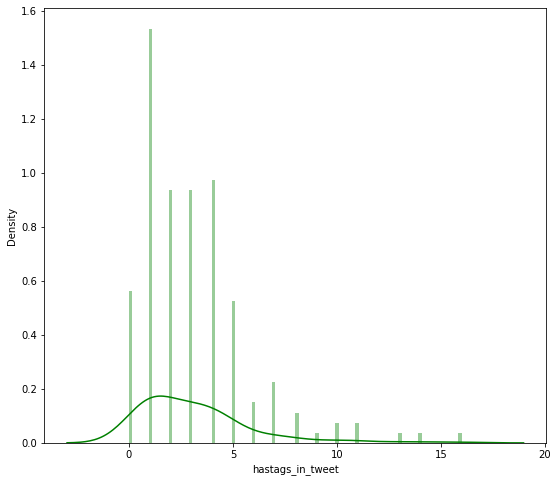

In [ ]:
print(df['hastags_in_tweet'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['hastags_in_tweet'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Tratamiento 'status_count'

*  Atipicos =   78148 + 1,5 * 204349 = 384671
*  Atipicos extremo =  78148 + 3 * 204349 = 691195

count    1.670000e+02
mean     7.814811e+04
std      2.043497e+05
min      1.000000e+00
25%      2.396000e+03
50%      1.361200e+04
75%      4.586100e+04
max      1.424909e+06
Name: status_count, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


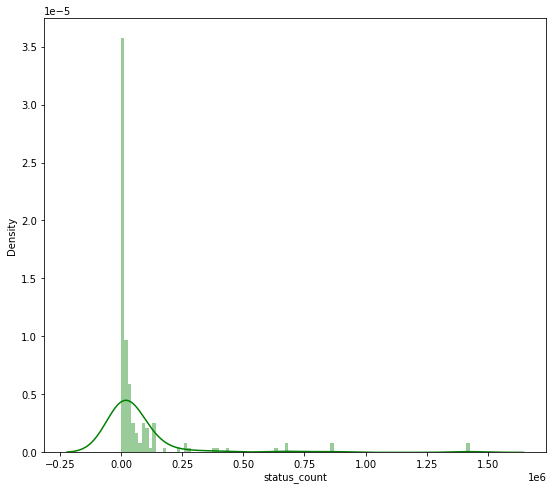

In [ ]:
print(df['status_count'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['status_count'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Tratamiento 'mentions_in_tweet'

*  Atipicos =  la media + 1,5 * std = 2.25
*  Atipicos extremo =  la media + 3 * std = 3.68

count    167.000000
mean       0.838323
std        0.952595
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        5.000000
Name: mentions_in_tweet, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


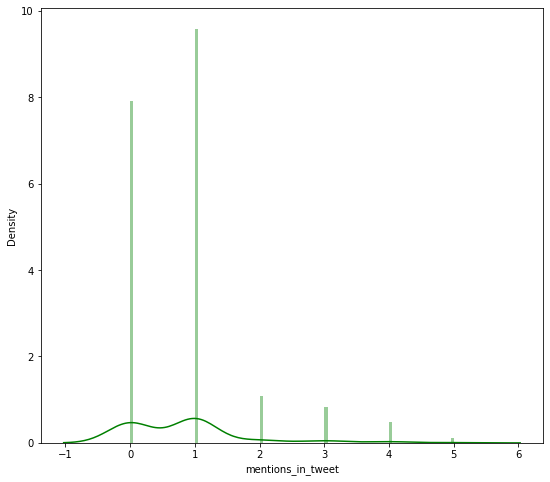

In [ ]:
print(df['mentions_in_tweet'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['mentions_in_tweet'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Tratamiento 'favorite_count'

*  Atipicos =  la media + 1,5 * std = 7
*  Atipicos extremo =  la media + 3 * std = 13

count    167.000000
mean       1.011976
std        3.999982
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       45.000000
Name: favorite_count, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


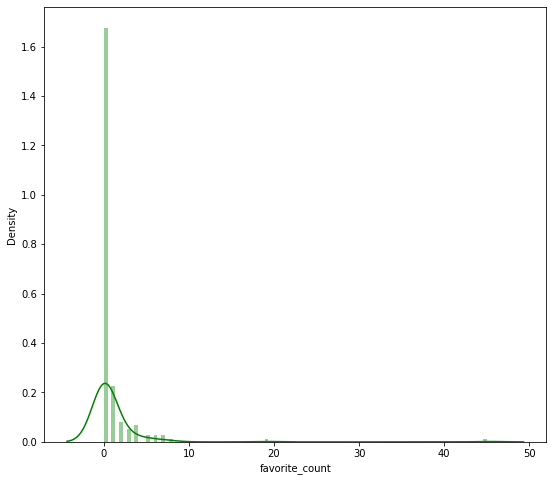

In [ ]:
print(df['favorite_count'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['favorite_count'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Tratamiento 'retweet_count'

*  Atipicos = la media + 1,5 * std = 8.28
*  Atipicos extremo = la media + 3 * std = 14

count    167.000000
mean       2.502994
std        3.866561
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       14.000000
Name: retweet_count, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


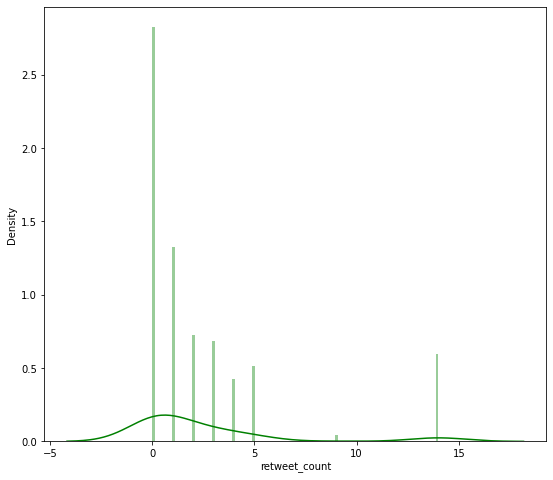

In [ ]:
print(df['retweet_count'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['retweet_count'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167 entries, 0 to 166
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   text                        167 non-null    object
 1   created_at                  167 non-null    object
 2   created_at_time             167 non-null    object
 3   created_at_hour             167 non-null    int64 
 4   retweeted                   167 non-null    object
 5   retweet_count               167 non-null    int64 
 6   favorite_count              167 non-null    int64 
 7   user_ verified              0 non-null      object
 8   user_id                     167 non-null    int64 
 9   user_name                   167 non-null    object
 10  user_location               167 non-null    object
 11  user_notificacion           167 non-null    object
 12  user_followers              167 non-null    int64 
 13  user_friends                167 non-null    int64 

# Tratamiento de variables categóricas

*  text	
*  created_at	
*  created_at_time
*  retweeted
*  user_ verified
*  user_name	
*  user_location
*  user_notificacion	
*  user_withheld_in_countries	
*  is_reply	
*  source_device	    #revisar
*  finished_tweet	
*  hashtags_text	
*  hastags_indices

In [62]:
df_cat = df.select_dtypes(include = 'object')
df_cat.head()

,text,created_at,created_at_time,retweeted,user_ verified,user_name,user_location,user_notificacion,user_withheld_in_countries,is_reply,source_device,finished_tweet,hashtags_text,hastags_indices
0,Según los resultados del primer Ranking de la ...,Tue Jul 20,14:02:33,Si,NaN,Fox_DelMonteFox,"Tacna, Peru",False,[],No,Android,False,['Telefónica'],"[[105, 116]]"
1,Según los resultados del primer Ranking de la ...,Tue Jul 20,14:00:04,Si,NaN,GatoNeg21801402,Lima,False,[],No,Android,False,['Telefónica'],"[[105, 116]]"
2,Las operadoras #Telefónica y #Entel son las em...,Tue Jul 20,13:59:51,Si,NaN,Reysond18,Huachano de paso por el mundo,False,[],No,Android,False,"['Telefónica', 'Entel']","[[34, 45], [48, 54]]"
3,Según los resultados del primer Ranking de la ...,Tue Jul 20,13:58:44,Si,NaN,FpDaria,"Lima, peru",False,[],No,Android,False,['Telefónica'],"[[105, 116]]"
4,Según los resultados del primer Ranking de la ...,Tue Jul 20,13:57:38,Si,NaN,kahn0808,,False,[],No,Android,False,['Telefónica'],"[[105, 116]]"


### Tratamiento 'text'	

### Tratamiento  'created_at'	


### Tratamiento 'created_at_time'


### Tratamiento  'retweeted'


In [120]:
# No creo que haya que hacer nada sobre ella
df['retweeted'].value_counts()

Si    226
No    126
Name: retweeted, dtype: int64

### Tratamiento  'user_ verified'


In [121]:
# Esta variable no sale bien,       hay que revisarla !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['user_ verified'].value_counts()

Series([], Name: user_ verified, dtype: int64)

### Tratamiento  'user_name'


### Tratamiento  'user_location'


In [122]:
df['user_location'].value_counts()

                      123
Lima, Peru             18
Perú                   15
España                 15
Caracas, Venezuela     14
                     ... 
Ecuador                 1
México                  1
Castilla y León         1
Distrito federal        1
lima - peru             1
Name: user_location, Length: 103, dtype: int64

In [ ]:
df.isnull().sum()

text                            0
created_at                      0
created_at_time                 0
created_at_hour                 0
retweeted                       0
retweet_count                   0
favorite_count                  0
user_ verified                235
user_id                         0
user_name                       0
user_location                   0
user_notificacion               0
user_followers                  0
user_friends                    0
user_withheld_in_countries      0
mentions_in_tweet               0
is_reply                        0
source_device                   0
finished_tweet                  0
status_count                    0
hashtags_text                   0
hastags_indices                 0
hastags_in_tweet                0
URLs                            0
dtype: int64

In [ ]:
df['user_location'].value_counts()

### Tratamiento  'user_notificacion'

In [126]:
# Si no es False, ¿qué pone? ¿sale vacio?
df['user_notificacion'].value_counts()

False    352
Name: user_notificacion, dtype: int64

### Tratamiento  'user_withheld_in_countries'


In [127]:
df['user_withheld_in_countries'].value_counts()

[]    352
Name: user_withheld_in_countries, dtype: int64

### Tratamiento  'is_reply'


In [129]:
#Quizá sería mejor tener esta variable como "Si - No" y otra en la que dijera cuál es, por si hubiera uno que se repite mucho.

df['is_reply'].value_counts()

No                 335
NoticiasdeAita       2
mameri9              2
MovistarPeru         1
GraphicsbyNight      1
JoseAGzlez           1
FabianHdezR          1
Telefonica           1
IdiazAyuso           1
jmalvpal             1
ARTUROGOMEZ13        1
martinhidalgo        1
Movistar_Team        1
WaykaPeru            1
esotobordoy          1
euri_cabral          1
Name: is_reply, dtype: int64

### Tratamiento 'source_device'

Recateogrización


In [89]:
df['source_device'].value_counts()

Twitter for Android        186
Twitter Web App             77
Twitter for iPhone          28
TweetDeck                   15
qpev20212                   13
dlvr.it                     10
Hootsuite Inc.               6
Twitter for iPad             4
Buffer                       2
Postcron App                 2
Metricool                    2
bms_twitter_MercadosNWS      1
FIUPM Bot                    1
ecu11                        1
BrenpCom                     1
de.elyex.com                 1
EcuaBot 2.0                  1
elyex.com                    1
Name: source_device, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


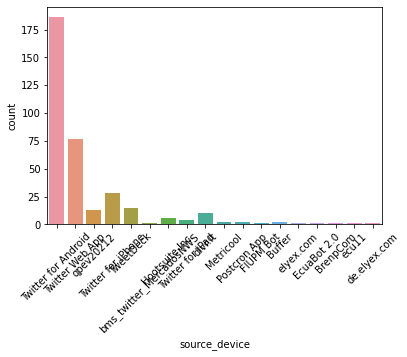

In [90]:
 sns.countplot(df['source_device'])
 plt.xticks(rotation=45)
plt.xticks(fontsize=10)
 plt.show()

In [115]:
# lo ideal sería hacerlo en un bucle. Lo he intentado pero no he podido. Además dependiendo del número de tweets que descarguemos esto cambia.
# hay que darle una pensada
#Se pueden fijar las principales categorías y lo que sea distinto de eso, recategorizarlo en "Otros"
df.loc[df['source_device'] == 'Twitter for Android', 'source_device'] = 'Android'
df.loc[df['source_device'] == 'Twitter for iPhone', 'source_device'] = 'Apple'
df.loc[df['source_device'] == 'Twitter for iPad', 'source_device'] = 'Apple'  #### lo metemos en categoría "apple"
df.loc[df['source_device'] == 'Twitter Web App', 'source_device'] = 'Web_app'  #### 
df.loc[df['source_device'] == 'TweetDeck', 'source_device'] = 'Web_app'  #### 

df.loc[df['source_device'] == 'qpev20212', 'source_device'] = 'Otros'
df.loc[df['source_device'] == 'Hootsuite Inc.', 'source_device'] = 'Otros'
df.loc[df['source_device'] == 'dlvr.it', 'source_device'] = 'Otros'
df.loc[df['source_device'] == 'BrenpCom', 'source_device'] = 'Otros'
df.loc[df['source_device'] == 'Buffer', 'source_device'] = 'Otros'
df.loc[df['source_device'] == 'Postcron App', 'source_device'] = 'Otros'
df.loc[df['source_device'] == 'de.elyex.com', 'source_device'] = 'Otros'
df.loc[df['source_device'] == 'ecu11', 'source_device'] = 'Otros'
df.loc[df['source_device'] == 'FIUPM Bot', 'source_device'] = 'Otros'
df.loc[df['source_device'] == 'elyex.com', 'source_device'] = 'Otros'
df.loc[df['source_device'] == 'Metricool', 'source_device'] = 'Otros'
df.loc[df['source_device'] == 'EcuaBot 2.0', 'source_device'] = 'Otros'
df.loc[df['source_device'] == 'bms_twitter_MercadosNWS', 'source_device'] = 'Otros'

df['source_device'].value_counts()


Android    186
Web_app     92
Otros       42
Apple       32
Name: source_device, dtype: int64

In [119]:
#Idea para hacerlo de forma automática:
# recategorizo esas principales y las que no sean 
#Android   #Web_app      #Apple       
#meterlo en la cateogría "Otros"
df['source_device'].value_counts()


### Tratamiento  ' finished_tweet'	


In [130]:
#Salen todos False
df['finished_tweet'].value_counts()

False    352
Name: finished_tweet, dtype: int64

### Tratamiento  'hashtags_text'


In [131]:
# Este no sé ni por donde cogerlo
# Quizá para el topic model nos pueda servir
df['hashtags_text'].value_counts()

['Telefónica']                                                                                                                                                                                  99
['Telefónica', 'Entel']                                                                                                                                                                         70
['Nacionales', 'empresa', 'telefónica']                                                                                                                                                         13
[]                                                                                                                                                                                              13
['accidentelaboral', 'subcontrata', 'Telefonica', 'movistar']                                                                                                                                   13
                         

### Tratamiento  'hastags_indices'


In [132]:
# Este no sé ni por donde cogerlo
# Quizá para el topic model nos pueda servir
df['hastags_indices'].value_counts()

TypeError: ignored

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[[105, 116]]                                                                     70
[[34, 45], [48, 54]]                                                             69
[]                                                                               13
[[23, 40], [48, 60], [64, 75], [76, 85]]                                         13
[[0, 11], [12, 20], [21, 32]]                                                    13
                                                                                 ..
[[9, 18], [19, 30], [31, 35], [124, 133], [134, 145], [146, 150], [255, 273]]     1
[[0, 11], [184, 192]]                                                             1
[[24, 35], [47, 56]]                                                              1
[[68, 79]]                                                                        1
[[0, 11], [17, 25], [81, 96], [97, 110], [111, 128], [129, 140]]                  1
Name: hastags_indices, Length: 131, dtype: int64

## Análisis de emojis


In [ ]:
# Download emoji sentiment
!wget https://www.clarin.si/repository/xmlui/handle/11356/1048/allzip
!unzip allzip
!pip install emoji_extractor
!pip install emoji

--2021-07-15 15:46:10--  https://www.clarin.si/repository/xmlui/handle/11356/1048/allzip
Resolving www.clarin.si (www.clarin.si)... 95.87.154.205
Connecting to www.clarin.si (www.clarin.si)|95.87.154.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘allzip’

allzip                  [  <=>               ]  94.61K   369KB/s    in 0.3s    

2021-07-15 15:46:11 (369 KB/s) - ‘allzip’ saved [96878]

Archive:  allzip
  inflating: ESR_v1.0_format.txt     
  inflating: Emoji_Sentiment_Data_v1.0.csv  
  inflating: Emojitracker_20150604.csv  
  Created wheel for emoji-extractor: filename=emoji_extractor-1.0.19-cp37-none-any.whl size=61586 sha256=465798009b8bc816c38b0eae82e1aacf2962f1999ed15a0451214361861e9324
  Stored in directory: /root/.cache/pip/wheels/87/bd/5f/e0108b9a84b63b2a0379397d5dada523360c26a46342d5c1a4
Successfully built emoji-extractor
     |████████████████████████████████| 133kB 5.3MB/s 


In [ ]:
from emoji_extractor.extract import Extractor

In [ ]:
# Vamosa generar el diccionario de emoticonos 
def load_emoji_sentiment(path):
  # Cargamos el csv de emoji_sentiment
  emoji_sent_df = pd.read_csv(path,sep=",")
  # Calculamos los scores dividiendo el número de emojis negativos y entre el total
  emoji_sent_df["Negative"] = emoji_sent_df["Negative"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Neutral"] = emoji_sent_df["Neutral"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Positive"] = emoji_sent_df["Positive"]/emoji_sent_df["Occurrences"]
  # Transformamos a dict
  emoji_sent_df = emoji_sent_df.set_index('Emoji')
  emoji_dict = emoji_sent_df.to_dict(orient="index")
  return emoji_dict

In [ ]:
# Función para extraer emojis del texto en formato lista
def extract_emojis(text):
  extract = Extractor()
  emojis = extract.count_emoji(text, check_first=False)
  emojis_list = [key for key, _ in emojis.most_common()]
  return emojis_list

In [ ]:
# Calcula el sentimiento de los emojis de una lista utilizando el diccionario
# de emoji sentiment score generado previamente con la función load_emoji_sentiment()
# Se puede extraer el valor de positividad de los emojis con la option "positive"
# Se puede extraer el valor de neutralidad de los emojis con la option "neutral""  
# Se puede extraer el valor de e negatividad de los emojis con la option "negative""  

def get_emoji_sentiment(lista, option = "positive"):
  output = 0
  for emoji in lista:
    try:
      if option == "positive":
        output = output + emoji_sent_dict[emoji]["Positive"]
      elif option =="negative":
        output = output + emoji_sent_dict[emoji]["Negative"]
      elif option =="neutral":
        output = output + emoji_sent_dict[emoji]["Neutral"]
    except Exception as e: 
      continue
  return output

In [ ]:
# Eliminar los emojis de un texto. Esto es útil porque una vez extraido los emojis
# puede interesarnos tener un texto sin presencia de emojis para mejor análisis.
def clean_emoji(text):
    # Poner todos los comandos de http://www.unicode.org/Public/emoji/1.0/emoji-data.txt
    emoji_pattern = re.compile("["
        u"\U0001F300-\U0001F6FF"  # symbols & pictographs
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u'\u2600-\u26FF\u2700-\u27BF'
        u'\u2934' u'\u2935' u'\u2B05' u'\u2B06' u'\u2B07' u'\u2B1B' u'\u2B1C' 
        u'\u2B50' u'\u2B55' u'\u3030' u'\u303D' u'\u3297' u'\u3299' u'\u00A9'
        u'\u00AE' u'\u203C' u'\u2049' u'\u2122' u'\u2139' u'\u2194-\u2199' 
        u'\u21A9' u'\u21AA' u'\u231A' u'\u231B' u'\u2328' u'\u23CF'
        u'\u23E9-\u23F3' u'\u23F8' u'\u23F9' u'\u23FA' u'\u24C2' u'\u25AA'
        u'\u25AB' u'\u25B6' u'\u25C0' u'\u25FB' u'\u25FD' u'\u25FC' u'\u25FE'
        ']+', flags=re.UNICODE)
    string2 = re.sub(emoji_pattern,r' ',text)
    return string2

In [ ]:
emoji_sent_dict = load_emoji_sentiment("Emoji_Sentiment_Data_v1.0.csv")

In [ ]:
emoji_sent_dict["🎉"]

{'Negative': 0.03822222222222222,
 'Neutral': 0.184,
 'Occurrences': 1125,
 'Position': 0.743635879,
 'Positive': 0.7777777777777778,
 'Unicode block': 'Miscellaneous Symbols and Pictographs',
 'Unicode codepoint': '0x1f389',
 'Unicode name': 'PARTY POPPER'}

In [ ]:
# Vamos a trabajar primero con los emojis
df["emoji_list"] = df["text_limpio"].apply(lambda x: extract_emojis(x))

In [ ]:
# vemos que hemos guardado en esta lista
df["emoji_list"]

0            []
1            []
2            []
3    [🗣, ✍, 🇻🇪]
4            []
Name: emoji_list, dtype: object

In [ ]:
df["sent_emoji_pos"] = df["emoji_list"].apply(lambda x: get_emoji_sentiment(x, "positive"))
df["sent_emoji_neu"] = df["emoji_list"].apply(lambda x: get_emoji_sentiment(x, "neutral"))
df["sent_emoji_neg"] = df["emoji_list"].apply(lambda x: get_emoji_sentiment(x, "negative"))

In [ ]:
df


,created_at,retweet_count,favorite_count,user_name,user_location,user_followers,user_verified,mentions_in_tweet,text,is_reply,source_device,finished_tweet,user_notificacion,user_withheld_in_countries,status_count,hashtags_text,hastags_indices,text_limpio,rt,url,emoji_list,sent_emoji_pos,sent_emoji_neu,sent_emoji_neg
0,Thu Jul 15 15:42:32 +0000 2021,9,0,Melissa58061855,,25,False,1,RT @ConElMazoDando: Sunad lanza la línea telef...,False,Twitter for Android,False,False,[],27473,CubaYVenezuelaUnaSolaBandera,"[[91, 120]]",Sunad lanza la línea telefónica 0800Sindrogas...,si,https://t.co/AuiHOHWfRE,[],0.0,0.0,0.0
1,Thu Jul 15 15:42:26 +0000 2021,0,0,AngelaTrivio3,,0,False,1,"@CNT_EC pésimo servicio, desde octubre 2020, t...",False,Twitter for iPad,False,False,[],7,,[],"@CNT_EC pésimo servicio, desde octubre 2020, t...",no,no,[],0.0,0.0,0.0
2,Thu Jul 15 15:42:24 +0000 2021,7,0,XxcvrenatoxX,Lima Perú,156,False,1,RT @MarvelLatin: James Gunn reveló que fue el ...,False,Twitter Web App,False,False,[],7962,,[],James Gunn reveló que fue el mismo Kevin Feig...,si,no,[],0.0,0.0,0.0
3,Thu Jul 15 15:42:22 +0000 2021,62,0,carmendelmila56,Venezuela,242,False,2,RT @Mippcivzla: 🗣️ ¡𝐓𝐨𝐦𝐚 𝐍𝐨𝐭𝐚!✍️ 🇻🇪 \nMin. de ...,False,Twitter for Android,False,False,[],47558,,[],"🗣️ ¡𝐓𝐨𝐦𝐚 𝐍𝐨𝐭𝐚!✍️ 🇻🇪 \nMin. de Ecosocialismo, ...",si,no,"[🗣, ✍, 🇻🇪]",1.0,0.0,0.0
4,Thu Jul 15 15:41:45 +0000 2021,3,0,MarcelaGuti23,,0,False,1,"RT @HuilaGob: Aún hay cupos para cursos ""Apren...",False,Twitter for Android,False,False,[],31,,[],"Aún hay cupos para cursos ""Aprende a hacer es...",si,no,[],0.0,0.0,0.0
